# **Introduction**

In this project, I analyze the Gowalla social network dataset, a large-scale graph that represents user check-in relationships collected from the now-defunct location-based social networking platform Gowalla. Each record in the dataset describes a directed connection between two users, forming a complex social network.

The main goal of the project is to identify the most influential users in this network using the PageRank algorithm, a fundamental link analysis technique introduced by Google to rank web pages based on their connectivity and influence. This algorithm was implemented using Apache Spark, leveraging distributed computation to efficiently process and analyze the massive dataset.

This project belongs to the Algorithms for Massive Data course, and it demonstrates the application of key topics covered in the lectures, including link analysis, MapReduce, and distributed data processing frameworks. The following sections describe each step of the analysis pipeline, from data loading and preprocessing to PageRank computation, visualization, and interpretation of results.

**✅ Phase 1 – Setup Spark Environment**

⏩ Step 1.1 – Install & Configure Spark

In [1]:
# Install the correct PySpark version — no manual Spark setup!
!pip install -q pyspark==3.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.


⏩ Step 1.2 – Start Spark Session

In [5]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder \
    .appName("GowallaPageRank") \
    .getOrCreate()

# Access SparkContext
sc = spark.sparkContext

# Simple test
print("Count =", sc.parallelize([1, 2, 3]).count())

Count = 3


**✅ Phase 2 – Load & Prepare Dataset**

⏩ Step 2.1 – Upload Gowalla_edges.csv

⏩ Step 2.2 – Preview the Raw Data

In [6]:
!head /content//Gowalla_edges.csv

0,1
0,2
0,3
0,4
0,5
0,6
0,7
0,8
0,9
0,10


⏩ Step 2.3 – Load CSV as Edge RDD

In [7]:
# Load the dataset into Spark RDD
rdd = sc.textFile("/content/Gowalla_edges.csv")

# Parse each line into (source, destination) integer pairs
edges = rdd.map(lambda line: tuple(map(int, line.strip().split(","))))

# Preview first 5 edges
edges.take(5)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

**✅ Phase 3 – Build the Graph Structure**

⏩ Step 3.1 – Create Link Mapping: node → [neighbors]

In [8]:
# Group edges by source node to build the graph structure
links = edges.distinct().groupByKey().cache()

# Preview a few links
links.mapValues(list).take(5)

[(0,
  [2,
   4,
   6,
   8,
   10,
   12,
   14,
   16,
   18,
   20,
   22,
   24,
   26,
   28,
   30,
   32,
   34,
   36,
   38,
   40,
   42,
   44,
   46,
   48,
   50,
   52,
   54,
   56,
   58,
   60,
   62,
   64,
   66,
   68,
   70,
   72,
   74,
   76,
   78,
   80,
   82,
   84,
   86,
   88,
   90,
   92,
   94,
   96,
   98,
   100,
   102,
   104,
   106,
   108,
   110,
   112,
   114,
   116,
   118,
   120,
   122,
   124,
   126,
   128,
   130,
   132,
   134,
   136,
   138,
   140,
   142,
   144,
   146,
   148,
   150,
   152,
   154,
   156,
   158,
   160,
   162,
   164,
   166,
   168,
   170,
   172,
   174,
   176,
   178,
   180,
   182,
   184,
   186,
   188,
   190,
   192,
   194,
   196,
   198,
   200,
   202,
   204,
   206,
   208,
   210,
   212,
   214,
   216,
   218,
   220,
   222,
   224,
   226,
   228,
   230,
   232,
   234,
   236,
   238,
   240,
   242,
   244,
   246,
   248,
   250,
   252,
   254,
   256,
   258,
   260,
   262,


**✅ Phase 4 – Run PageRank Algorithm**

⏩ Step 4.1 – Initialize Ranks

In [9]:
# Initialize each node's rank to 1.0
ranks = links.mapValues(lambda neighbors: 1.0)

⏩ Step 4.2 – Define Iterations

In [10]:
for i in range(10):
    # Join links and ranks: (node, ([neighbors], rank))
    contributions = links.join(ranks).flatMap(
        lambda node_links_rank: [
            (neighbor, node_links_rank[1][1] / len(node_links_rank[1][0]))
            for neighbor in node_links_rank[1][0]
        ]
    )

    # Recompute rank: new rank = sum of contributions
    ranks = contributions.reduceByKey(lambda x, y: x + y).mapValues(lambda rank: 0.15 + 0.85 * rank)

⏩ Step 4.3 – Preview Final Ranks

In [11]:
# Show top 10 ranked nodes
for node, rank in ranks.takeOrdered(10, key=lambda x: -x[1]):
    print(f"Node {node} has rank: {rank:.4f}")

Node 3 has rank: 118.9470
Node 505 has rank: 80.0658
Node 2 has rank: 73.9834
Node 220 has rank: 53.6859
Node 307 has rank: 51.5844
Node 1 has rank: 46.9471
Node 207 has rank: 39.1148
Node 615 has rank: 33.8233
Node 5 has rank: 28.5196
Node 0 has rank: 26.1046


In [12]:
# Recreate Spark DataFrame from your ranks RDD
ranks_df = ranks.toDF(["node", "pagerank"])

In [13]:
# Convert Spark DataFrame to Pandas for plotting
top_ranks_pd = ranks_df.toPandas()

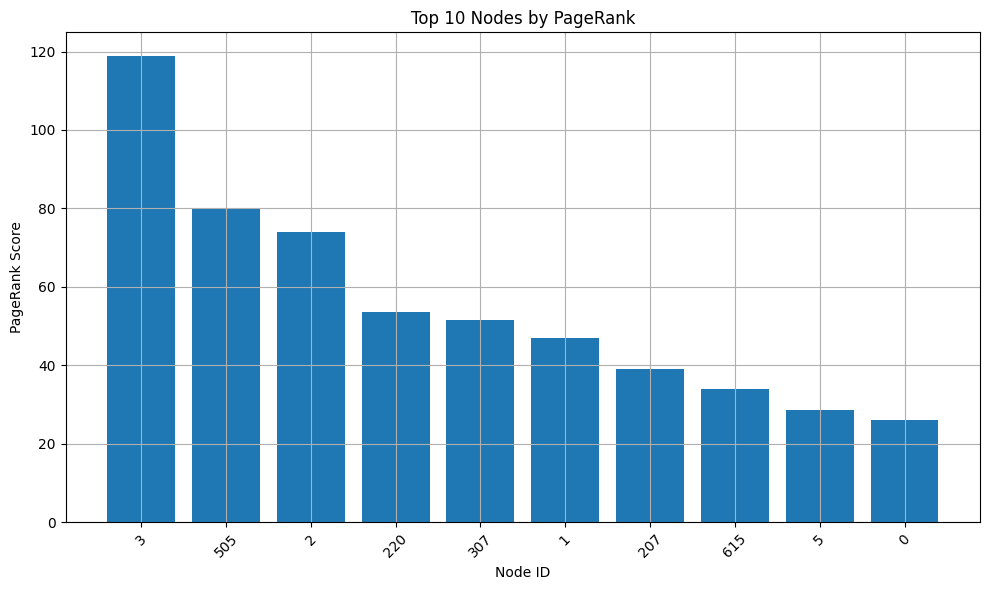

In [14]:
import matplotlib.pyplot as plt

# Sort by rank
top10 = top_ranks_pd.sort_values("pagerank", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top10["node"].astype(str), top10["pagerank"])
plt.title("Top 10 Nodes by PageRank")
plt.xlabel("Node ID")
plt.ylabel("PageRank Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

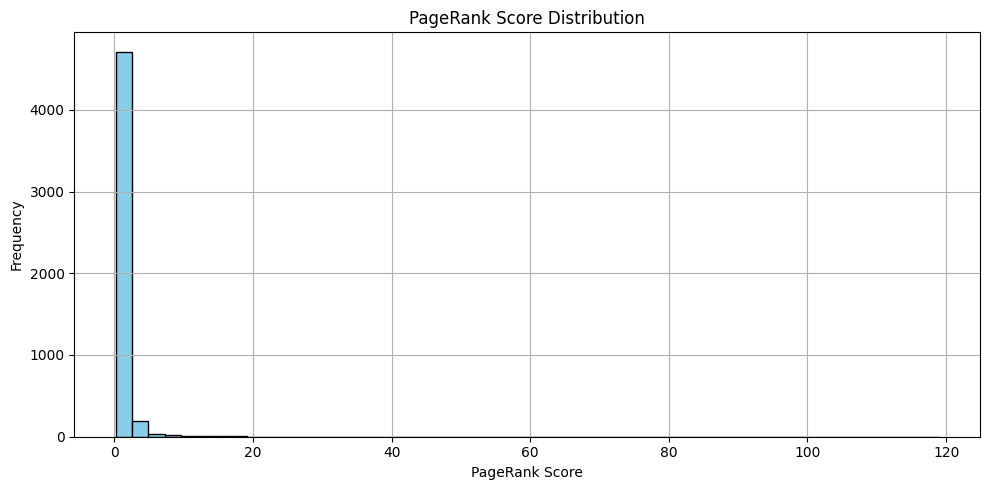

In [15]:
# Plot histogram of all PageRank values
plt.figure(figsize=(10, 5))
plt.hist(top_ranks_pd["pagerank"], bins=50, color="skyblue", edgecolor="black")
plt.title("PageRank Score Distribution")
plt.xlabel("PageRank Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

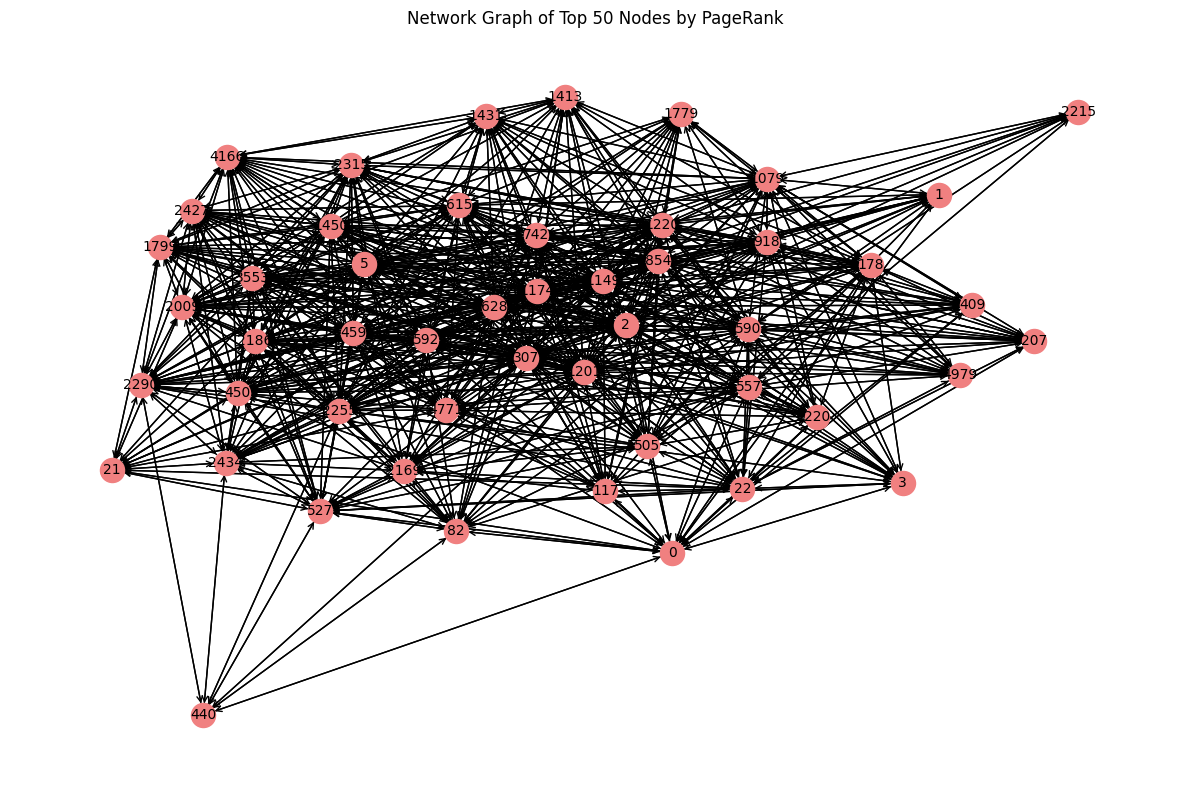

In [16]:
import networkx as nx

# Create NetworkX graph
G = nx.DiGraph()

# Add top 50 nodes by PageRank
top_nodes = set(top_ranks_pd.sort_values("pagerank", ascending=False).head(50)["node"])

# Filter original edges RDD to those with both nodes in top 50
top_edges = edges.filter(lambda x: x[0] in top_nodes and x[1] in top_nodes).collect()

# Add edges to NetworkX graph
G.add_edges_from(top_edges)

# Draw
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightcoral')
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=10)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Network Graph of Top 50 Nodes by PageRank")
plt.axis("off")
plt.tight_layout()
plt.show()

# **Discussion and Results Interpretation**

The PageRank analysis conducted on the Gowalla social network dataset reveals meaningful insights into the underlying structure of user interactions. The results show that a small number of users hold disproportionately high PageRank scores, indicating that influence within the network is highly concentrated among a few central hubs. These users are not only well-connected but are also connected to other highly influential individuals, amplifying their overall importance. The bar chart of the top ten nodes highlights this dominance, while the histogram of PageRank values demonstrates a heavily skewed distribution, confirming that Gowalla follows a scale-free or power-law structure — a common property of real-world social networks. The network visualization of the top 50 nodes further supports this observation, showing a dense core of interlinked influential users surrounded by peripheral, less-connected nodes. Overall, this experiment demonstrates how PageRank effectively captures the notion of importance and visibility in large-scale networks. By leveraging distributed computation in Apache Spark, the project also illustrates how algorithms originally developed for the Web can be applied efficiently to modern big data platforms to analyze massive datasets such as social graphs.